In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from collections import Counter
import spacy
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')

In [2]:
data = pd.read_csv("data/large/train.csv",encoding = "ISO-8859-1",names=["target","id","date","flag","user","text"])
data['text'] = data.text.progress_apply(lambda x: x.strip())
drop_idxs = [598051] #Remove problematic sentences
data = data.drop(index=drop_idxs)
data_vals = data.values

In [3]:
#Class counts
neg = np.where(data_vals[:,0] == 0)
pos = np.where(data_vals[:,0] == 4)
neu = np.where(data_vals[:,0] == 2)
print(len(neg[0]))
print(len(pos[0]))
print(len(neu[0]))

799999
800000
0


In [4]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
sentences = data_vals[:,5]

In [5]:
words = Counter()
for sentence in tqdm(sentences):
    try:
        words.update(word.text.lower() for word in nlp(sentence))
    except:
        print("Break, sentence", sentence)

In [6]:
words = sorted(words, key=words.get, reverse=True)
words = ['PAD','CTX','SOS','EOS'] + words

In [7]:
index_word = {x:y for x,y in enumerate(words)}
word_index = {y:x for x,y in enumerate(words)}

In [8]:
def indices_func(sentence):
    try:
        indices = [word_index[word.text.lower()] for word in nlp(sentence)]
        return indices
    except:
        print("Break, sentence: ",sentence)
    

data['indices'] = data.text.progress_apply(indices_func)
data['length'] = data.indices.progress_apply(len)


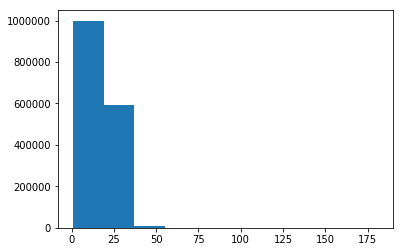

In [12]:
plt.hist(data.length.values)
plt.show();


In [43]:
dfind = pd.DataFrame.from_dict(index_word,orient="index")

In [53]:
dfind.to_csv("data/word_index.csv")
data.to_csv("data/large/processed.csv")